# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [1]:
import cv2
import os
import numpy as np
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import pandas as pd



In [2]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD


In [3]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,6)

In [4]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

10658925/10658925 [==============================] - 3s 0us/step


In [5]:
# Descomprimimos el archivo en tmp para visualizar
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons

In [6]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [7]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [8]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [9]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"


X_train, Y_train = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_test, Y_test = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)


Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [11]:
print(DATASET_TRAIN_PATH_COLAB)

/root/.keras/datasets/simpsons


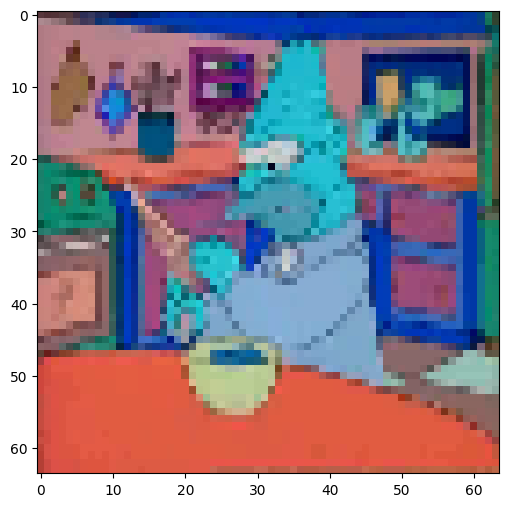

In [12]:
plt.imshow(X_train[2])

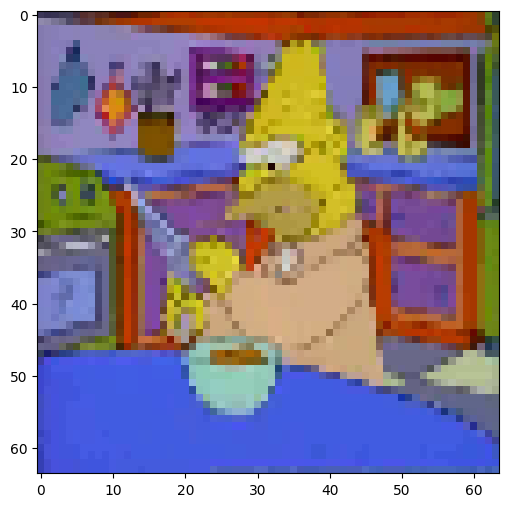

In [13]:
plt.imshow(np.flip(X_train[2], axis=-1) )

## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos para ser analizados en vuestro informe:

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas:
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

In [14]:
print("Datos de entrenamiento", X_train.shape)
print("datos de prueba", X_test.shape)

Datos de entrenamiento (18992, 64, 64, 3)
datos de prueba (890, 64, 64, 3)


Se hace una visualizacion de algunas de las imagenes del dataSet

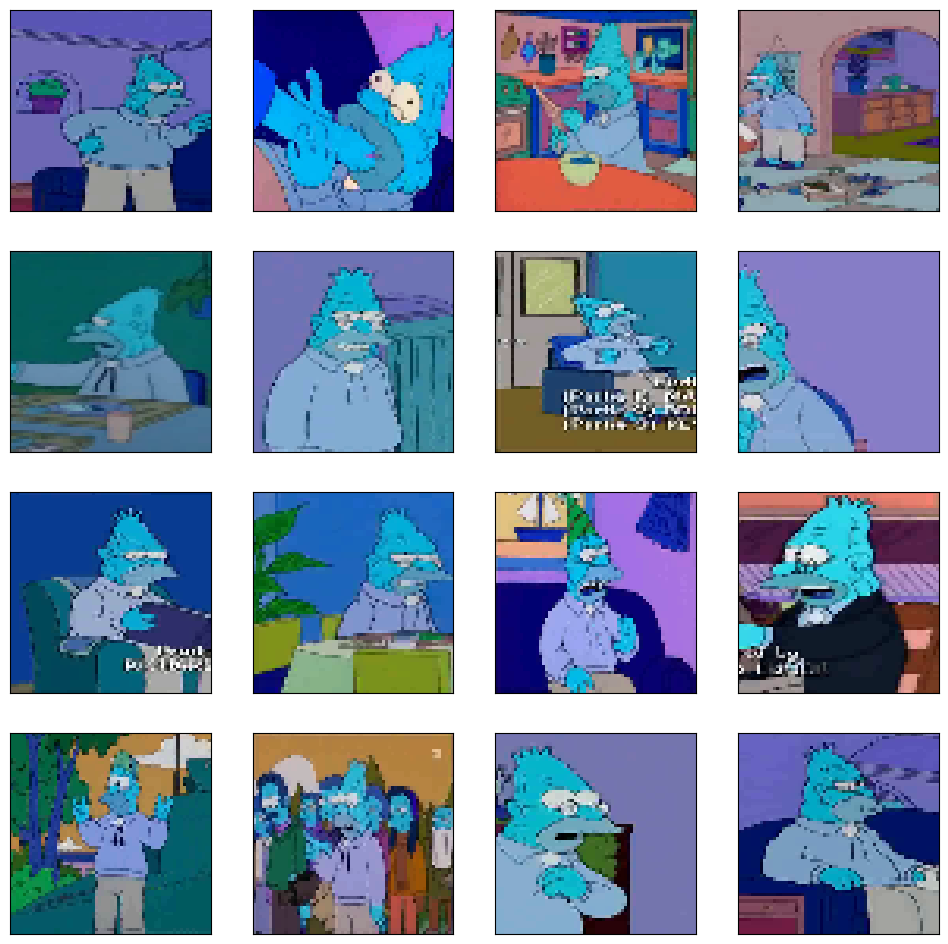

In [15]:
plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(X_train[i], cmap=plt.cm.binary)

Luego de ver los conjuntos de prueba y entrenamiento. Se procede a realizar la normalizacion de los respectivos dataSet. Tal como se explico en la primera actividad, debido a que los pixeles se encuentran entre 0-255 pixeles, las redes neuronales funcionan de manera eficiente con valores entre 0-1. Por ende al realizar esta transformacion los datos de los set quedan con valores entre 0-1 respectivamente

In [16]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Una vez que se normalizan los datos, se procede a obtener la lista de los nombres de todos los personajes.

Se crea una lista que tiene con las etiquetas de los personajes para el proceso a analizar. A pesar de haber 47 carpetas diferentes, al momento de crear MAP_CHARACTERS, unicamente se utilizan 18, que son los nombrados.

In [17]:
listaPersonajes = os.listdir(DATASET_TRAIN_PATH_COLAB)
print("cantidad total de personajes:", len(listaPersonajes))

class_names = ['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson','charles_montgomery_burns', 'chief_wiggum', 'comic_book_guy', 'edna_krabappel',
     'homer_simpson',  'kent_brockman',  'krusty_the_clown',  'lisa_simpson','marge_simpson', 'milhouse_van_houten',  'moe_szyslak','ned_flanders',  'nelson_muntz', 'principal_skinner',  'sideshow_bob']

cantidad total de personajes: 47


In [18]:
labels=Y_train;
labels_test=Y_test;
Y_train = keras.utils.to_categorical(Y_train, num_classes = 18)
Y_test = keras.utils.to_categorical(Y_test, num_classes = 18)

Capa de Pooling
Como habrás visto, las capas convolucionales permiten detectar patrones en la imagen pudiendo mantener el tamaño del resultado. ¿Qué es lo que pasa con eso? Pues básicamente que al mantener el tamaño de la imagen, el proceso es muy difícil. Al fin y al cabo una imagen tiene muchos píxeles. Para solucionar esto están las capas de pooling.


Las capas de pooling permiten reducir el peso de la representación para así agilizar el proceso de aprendizaje de la red neuronal. Además, suele hacer que el resultado de las capas convolucionales sea más robusto. Suena bien, pero, ¿en qué consisten?

El funcionamiento de una capa de pooling es bastante sencillo. Supongamos que tenemos una matriz de 4×4. Si aplicamos una capa de Max Pooling, por ejemlo, solo tendríamos que dividir la matriz en 4 cuadrantes y crear una nueva matriz con el valor más alto que haya dentro de cada uno de los resultados


 las capa de max pooling nos aseguran que los patrones detectados en la capa convolucional se mantengan en la siguiente capa de la red.


 https://anderfernandez.com/blog/que-es-una-red-neuronal-convolucional-y-como-crearlaen-keras/

In [30]:
#se crea el input shape con las dimensiones de 64*64 y las 3 dimensiones RGB
input_shape = (64, 64, 3)
batch_size = 128
num_classes = 18
epochs = 15

model = Sequential()

#se añade la primera capa
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

#se añade segunda capa
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

#se añade una tercera capa
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#aplicacion de flatten para usar una red fully connected
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
#model.add(Activation('relu'))

#capa softmax para poder clasificar las imagenes
model.add(Dense(num_classes, activation='softmax'))

model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 conv2d_19 (Conv2D)          (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 31, 31, 64)        18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 29, 29, 64)        36928     
                                                      

https://atcold.github.io/pytorch-Deep-Learning/es/week05/05-2/

In [37]:
#model.compile(loss='categorical_crossentropy',optimizer=SGD(lr=0.009, decay=1e-6, momentum=0.9, nesterov=True),metrics=['accuracy'])
model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [35]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False)

In [38]:
datagen.fit(X_train)

history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=(X_test, Y_test))



Epoch 1/15
148/148 [==============================] - 31s 181ms/step - loss: 0.7285 - accuracy: 0.7863 - val_loss: 0.3962 - val_accuracy: 0.8764
Epoch 2/15
148/148 [==============================] - 27s 179ms/step - loss: 0.5464 - accuracy: 0.8356 - val_loss: 0.3647 - val_accuracy: 0.8888
Epoch 3/15
148/148 [==============================] - 26s 178ms/step - loss: 0.4469 - accuracy: 0.8649 - val_loss: 0.2971 - val_accuracy: 0.9011
Epoch 4/15
148/148 [==============================] - 26s 178ms/step - loss: 0.4122 - accuracy: 0.8747 - val_loss: 0.2172 - val_accuracy: 0.9416
Epoch 5/15
148/148 [==============================] - 27s 181ms/step - loss: 0.3492 - accuracy: 0.8936 - val_loss: 0.1844 - val_accuracy: 0.9461
Epoch 6/15
148/148 [==============================] - 27s 182ms/step - loss: 0.3080 - accuracy: 0.9073 - val_loss: 0.1525 - val_accuracy: 0.9584
Epoch 7/15
148/148 [==============================] - 27s 180ms/step - loss: 0.2752 - accuracy: 0.9144 - val_loss: 0.1315 - val_ac

In [29]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('accuracy:', score[1])

y_pred = model.predict(X_test)
print(metrics.classification_report(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1), target_names=list(MAP_CHARACTERS.values())), sep='')

Y_pred_classes = np.argmax(y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

accuracy: 0.9370786547660828
28/28 [==============================] - 0s 9ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.98      0.83      0.90        48
  apu_nahasapeemapetilon       1.00      1.00      1.00        50
            bart_simpson       0.87      0.94      0.90        50
charles_montgomery_burns       0.98      0.85      0.91        48
            chief_wiggum       0.92      0.94      0.93        50
          comic_book_guy       0.98      0.92      0.95        49
          edna_krabappel       0.90      0.90      0.90        50
           homer_simpson       0.87      0.90      0.88        50
           kent_brockman       0.96      1.00      0.98        50
        krusty_the_clown       0.98      0.98      0.98        50
            lisa_simpson       0.93      0.86      0.90        50
           marge_simpson       1.00      1.00      1.00        50
     milhouse_van_houten       0.91      0.98      0.94    

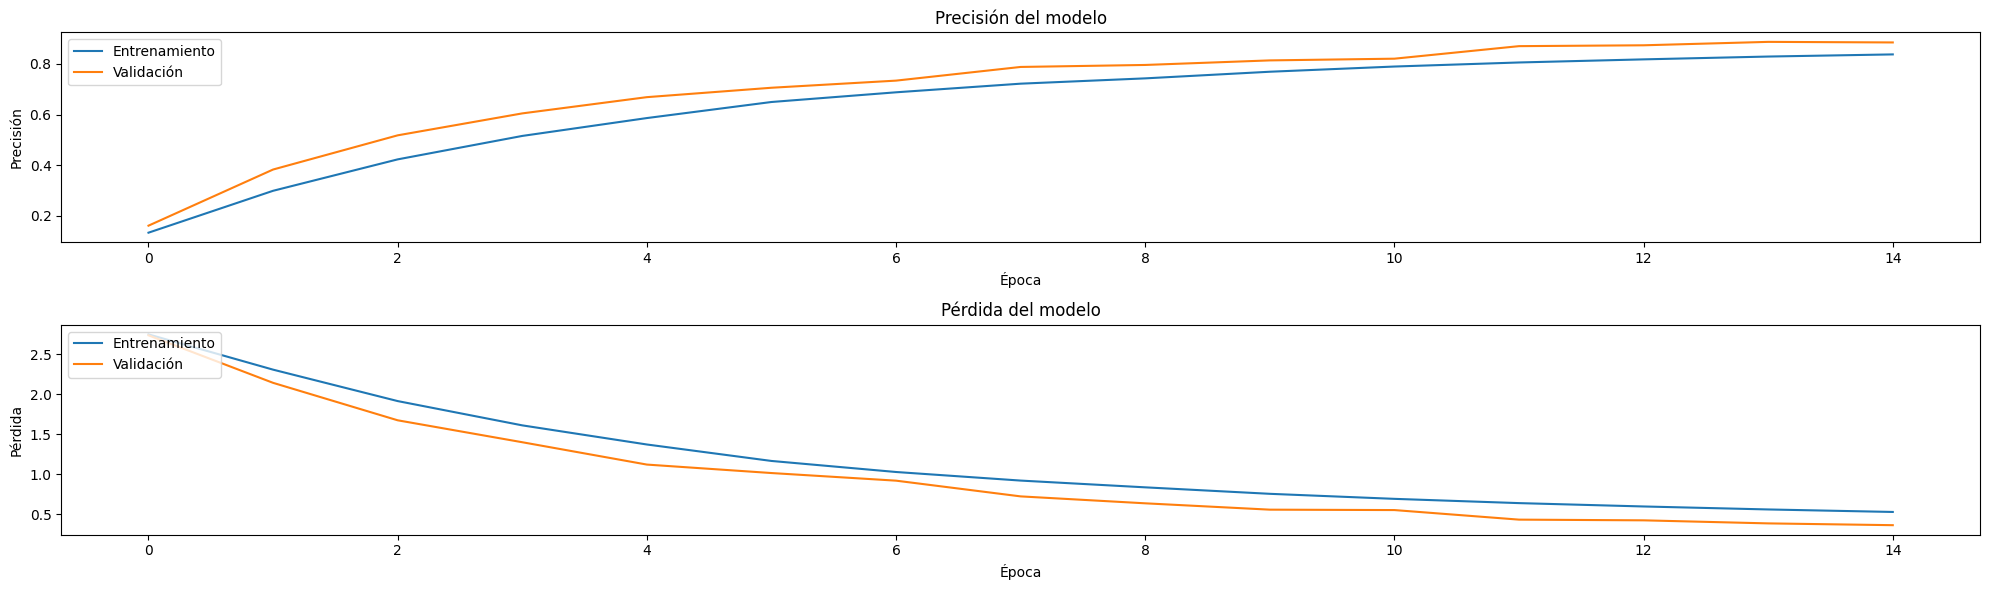

In [69]:
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.tight_layout()
plt.show()

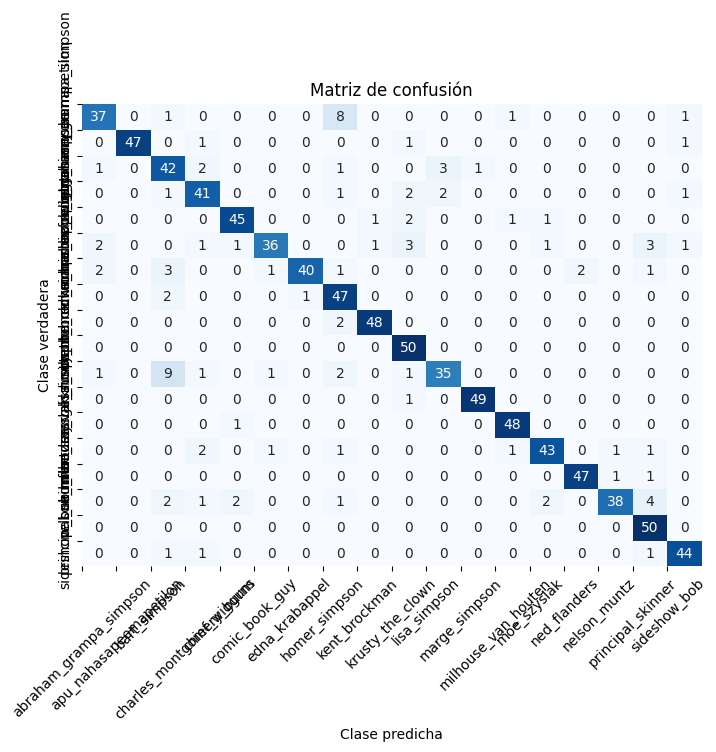

In [70]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Matriz de confusión')
plt.xlabel('Clase predicha')
plt.ylabel('Clase verdadera')
plt.xticks(ticks=np.arange(len(MAP_CHARACTERS)), labels=list(MAP_CHARACTERS.values()), rotation=45)
plt.yticks(ticks=np.arange(len(MAP_CHARACTERS)), labels=list(MAP_CHARACTERS.values()))
plt.show()

In [54]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)


In [55]:
model.save("/content/gdrive/My Drive/app/model.h5")
model.save_weights('/content/gdrive/My Drive/app/my_model_weights.h5')
model.save("/root/.keras/datasets/model.h5")
model.save_weights('/root/.keras/datasets/my_model_weights.h5')

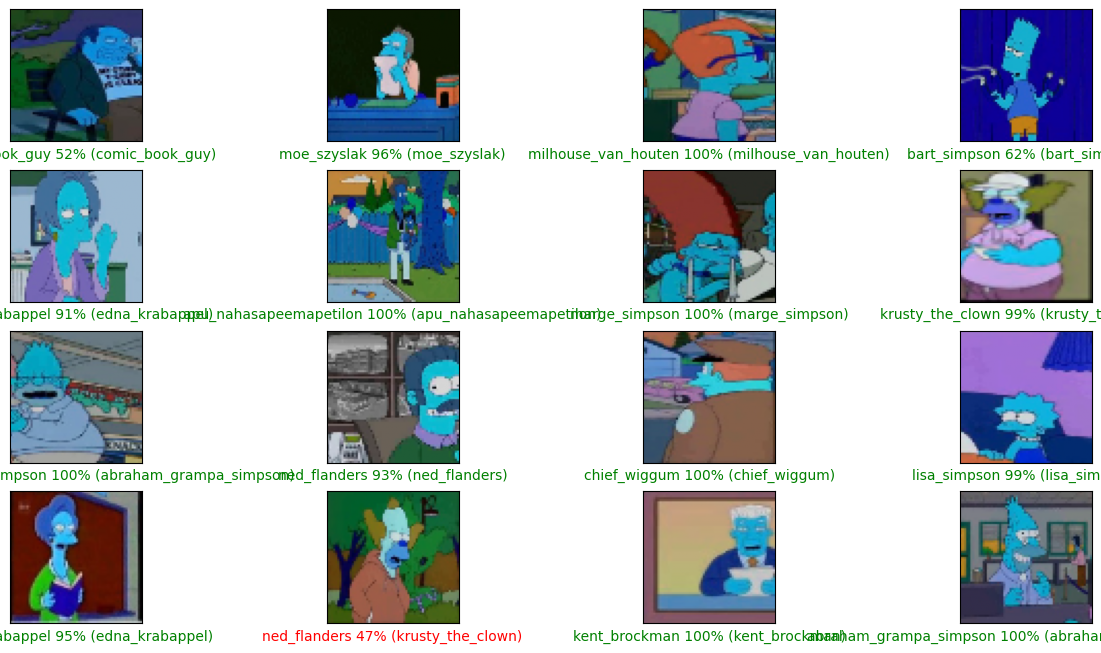

In [56]:
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, y_pred, labels_test, X_test)
